# Challenge Exercise: What insights can homology provide on a weather dataset?

Let's try to get insights from a real dataset our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset. There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

GOAL OF THIS EXERCISE: you have learned several data visualization/exploration tools. Use the functions on kmeans clustering, simplicial complexes, persistent homology, persistent diagrams, persistent barcodes, turning a time-series signal into a point cloud to try to derive an exploratory analysis of the provided dataset. Your goal is to understand and be able to explain clearly patterns that you observe in the dataset. Some things to try:
-  How would you slice the dataset? In what resolution are you looking for those patterns?
-  What is the connection between the target variable and the predictor variables? Can you derive some of these insights from the data?
- Is there a periodic footprint in the data? Could this be useful?

Dataset summary:
-  Target variable: flow (m3 / sec) – one location
- Predictor Variables: Precipitation (mm) and Temperature (deg C) – 9 locations
- Dates available: 1/1/1957 – 12/26/2016

## Data Cleanup

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

file = "C:/Users/guzma/OneDrive/Documents/TEC/S6/Geometria y topologia de datos/Reto/noaa_ai_workshop/IntroNotebooks/uke_eggedal_data_challenge.pkl"
df = pd.read_pickle(file)

In [5]:
for key in df.keys():
    print(len(df[key]))

21542
21546
21542
2
21546
21546


In [57]:
df1 = pd.DataFrame(df['flow'])
df1.columns = ['flow']
df2 = pd.DataFrame(df['obs_tas'])
df2.columns = ['tas_0', 'tas_1', 'tas_2', 'tas_3', 'tas_4', 'tas_5', 'tas_6', 'tas_7', 'tas_8']
df3 = pd.DataFrame(df['flow_dates'])
# df4 = pd.DataFrame(df['obs_lon_lat']) # ignore
df5 = pd.DataFrame(df['obs_pr'])
df5.columns = ['pr_0', 'pr_1', 'pr_2', 'pr_3', 'pr_4', 'pr_5', 'pr_6', 'pr_7', 'pr_8']
# df6 = pd.DataFrame(df['obs_dates']) # ignore

In [58]:
data = pd.concat([df1, df2], axis=1, join='inner')
data = pd.concat([data, df5], axis=1, join='inner')
# data = pd.concat([data, df3], axis=1, join='inner')
# data = pd.concat([data, df6], axis=1, join='inner')

In [59]:
data.set_index(df3[0])

,flow,tas_0,tas_1,tas_2,tas_3,tas_4,tas_5,tas_6,tas_7,tas_8,pr_0,pr_1,pr_2,pr_3,pr_4,pr_5,pr_6,pr_7,pr_8
0,,,,,,,,,,,,,,,,,,,
1958-01-04,1.723781,-10.600000,-9.7,-6.7,-8.800000,-8.900000,-7.500000,-8.1,-6.5,-5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
1958-01-05,0.960882,-20.500000,-19.1,-12.0,-17.700001,-17.700001,-13.100000,-15.5,-11.8,-9.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1
1958-01-06,0.001000,-23.600000,-22.5,-15.1,-21.400000,-21.400000,-16.299999,-19.4,-14.6,-12.2,0.1,0.0,0.3,0.1,0.3,0.3,0.4,0.3,0.5
1958-01-07,0.001000,-16.200001,-16.0,-14.1,-15.600000,-15.400000,-14.500000,-15.0,-13.8,-11.9,1.0,0.0,1.0,1.1,0.9,0.7,0.8,0.4,0.6
1958-01-08,0.316796,-7.900000,-7.8,-9.5,-7.600000,-7.500000,-8.000000,-7.4,-8.6,-8.2,9.3,8.6,8.0,8.9,8.7,10.2,9.3,10.1,9.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-22,4.843290,-1.600000,-0.8,0.7,0.200000,-0.100000,0.600000,0.7,1.1,1.5,2.6,2.9,2.5,2.8,2.8,2.7,1.5,1.1,2.6
2016-12-23,3.756970,-1.800000,-0.8,0.1,-0.100000,-0.200000,0.300000,0.4,0.5,1.0,1.7,1.4,0.5,1.2,0.9,0.0,1.2,0.0,0.0
2016-12-24,3.556818,-0.200000,0.6,3.4,1.700000,1.300000,2.900000,2.2,3.4,4.4,2.1,2.2,4.0,3.0,2.8,2.1,3.3,1.6,0.6


In [44]:
pca2 = PCA(n_components=2)
pca1 = PCA(n_components=1)
dat1 = pca1.fit_transform(data)
dat2 = pca2.fit_transform(data)

## Kmeans clustering

### 2 Components

In [45]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(dat2)
kmeans.labels_
center2 = kmeans.cluster_centers_

In [46]:
label = kmeans.fit_predict(data)
u_labels = np.unique(label)

In [47]:
dam = pd.DataFrame(dat2)
dam.shape

(21542, 2)

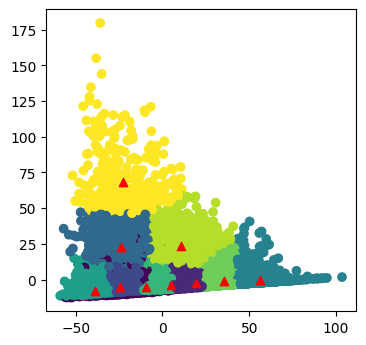

In [48]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(dat2[:,0], dat2[:,1], c=kmeans.labels_)
plt.scatter(center2[:,0],center2[:,1],marker = '^', c = 'r')
plt.show()

### 1 Component

In [57]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(dat1)
kmeans.labels_
center1 = kmeans.cluster_centers_

In [50]:
dam1 = pd.DataFrame(dat1)
dam1.shape

(21542, 1)

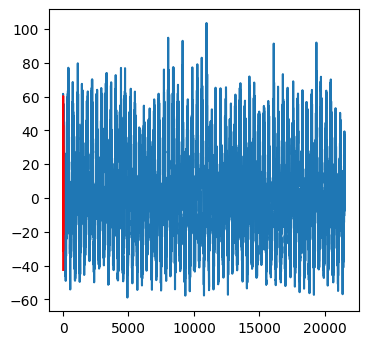

In [63]:
plt.figure(figsize=(4,4), dpi=100)
plt.plot(dat1)
plt.plot(center1, c='r')
plt.show()

## Simplicial Complexes

In [65]:
import networkx as nx

## Persistent Homology

## Persistent diagrams

## Persistent Barcodes

## Point Cloud